## Heart Attack Prediction Model 
## Final Model Interpretation
## Limitations
## Project Summary

---


## Author: Will Wu

## Date: 2025-04-02
---

## Introduction
This notebook is composed of three sections:
1. Interpreting the Final Model: Given that the final model is logistic regression, I will extract the coefficients to identify influential features and interpret the odds associated with each feature in predicting heart attack risk.

2. Analysis of Recall and False Positive Rate for Each Feature: I will conduct a detailed analysis of recall and false positive rate (FPR) for each category of the features. This analysis will identify limitations within the model, such as which age groups exhibit higher false positive rates and which have lower recall. Consequently, users will gain a more accurate understanding of how the model's performance relates to their personal conditions.

3. Project Summary: This section will provide an overview of the entire project, including the problem statement, proposed solution, success metrics, preprocessing steps, EDA findings, modeling, interpretations, and limitations of the models used.

---

## **Table of Contents** ##
1. [Setup and Load Data](#1)
2. [Reproduce the Predictions](#2)
3. [Interpreting the Models](#3)
    - [Retrieve and Transform Coefficients](#3a)
    - [Interpreting Coefficients](#3b)
4. [Breakdown Analysis of Recall and False Positive Rate](#4)
    - [Retrieve Prediction Outcomes](#4a)
    - [Visualize and Breakdown Analysis of Recall & FPR](#4b)
5. [Project Summary](#5)

---

## 1. Setup and Loading<a class="anchor" id="1"></a>

In [2]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sys
import os
from sklearn.model_selection import train_test_split
import joblib


In [3]:
# Get the current directory of the notebook
current_directory = os.getcwd()
src_directory = os.path.join(current_directory, '../src')
sys.path.append(src_directory)

# Import the self_created class
from model_evaluator import ModelEvaluator

In [4]:
# Configure Seaborn to use 'darkgrid' as the default background style
sns.set_style('darkgrid')

# Setting figure size, fontsize globally in the notebook
plt.rcParams["figure.figsize"] = (6.0, 6.0)

# Filter warnings 
from warnings import filterwarnings
filterwarnings(action='ignore')

In [5]:
# Load the data with feature selection
df = pd.read_csv('../data/processed/df_feature_selected.csv')

In [6]:
# Check the top five rows
df.head(5)

,is_female,race_ethnicity_category,age_category,bmi_category,alcohol_drinkers,general_health,smoker_status,physical_activities,had_angina,had_stroke,had_copd,had_diabetes,had_kidney_disease,had_depressive_disorder,had_arthritis,deaf_or_hard_of_hearing,blind_or_vision_difficulty,difficulty_walking,difficulty_dressing_bathing,had_heart_attack
0,1,White,80+,obese,No,Very good,Never,0,0,0,No,Yes,No,No,No,No,No,Yes,No,0
1,1,White,80+,overweight,No,Very good,Never,1,0,0,No,No,No,Yes,Yes,Yes,No,No,No,0
2,1,Black,80+,healthy,No,Fair,Former,1,0,0,No,No,No,No,Yes,Unknown,Yes,Yes,No,0
3,1,White,75-79,overweight,No,Very good,Never,1,0,0,No,No,No,Yes,Yes,No,No,Yes,No,0
4,1,White,75-79,overweight,Yes,Fair,Never,1,0,0,No,Yes,No,Yes,Yes,No,No,Yes,No,0


In [7]:
# Load the final model: logistic regression
final_model = joblib.load("../models/final_model/pipeline_logreg_final.joblib")

# Load the threshold of the model
model_threshold = final_model['logreg'].threshold
print(f'The threshold for the final model is {model_threshold}')

The threshold for the final model is 0.450002345959818


---

## 2. Reproduce the Predictions <a class="anchor" id="2"></a>

In this section, I will reproduce the predictions of the final model and re-evaluate its performance. The objectives are as follows:
1. Verify that the evaluation metrics align with those obtained during advanced modeling, ensuring that the predictions have been successfully reproduced.
2. Recap and analyze the confusion matrix, recall, and false positive rate of the model to assess its performance.

---

Create X and y

In [8]:
# Get X and y
X = df[[col for col in df.columns if col != 'had_heart_attack']]
y = df['had_heart_attack']

Train Test Split - Using the same random_state=42

In [9]:
# train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=1)

Reproduce the predictions to verify if the evaluation metrics align with those obtained previously in the advanced modeling process.

In [10]:
# Use the self-built function to make predictions with specified model threshold
evaluator = ModelEvaluator(final_model)
y_pred_train, y_pred_test = evaluator.make_predictions(X_train, X_test, thresholds=model_threshold)

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

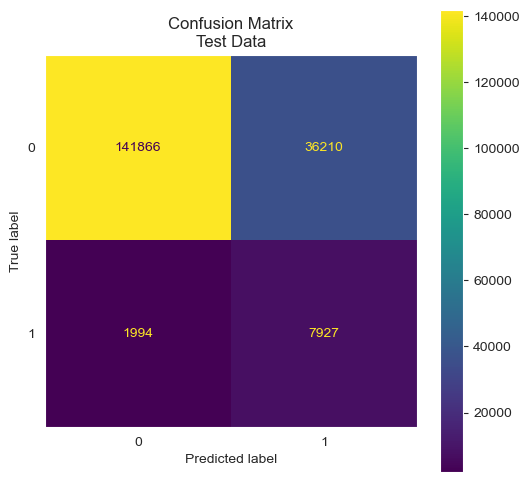

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.99      0.80      0.88    178076
           1       0.18      0.80      0.29      9921

    accuracy                           0.80    187997
   macro avg       0.58      0.80      0.59    187997
weighted avg       0.94      0.80      0.85    187997

Recall Score:
Train: 0.800
Test: 0.799 
False Positive Rate:
Train: 0.203
Test: 0.203 
AUC Score:
Train: 0.884
Test: 0.881 
Accuracy Score:
Train: 0.797
Test: 0.797 
Precision Score:
Train: 0.180
Test: 0.180 
F1 Score:
Train: 0.294
Test: 0.293 


In [11]:
# Reproduce model evaluation
evaluator.evaluate(X_train, X_test, y_train, y_test, thresholds=model_threshold)

ROC Curve: Logistic Regression Final Model


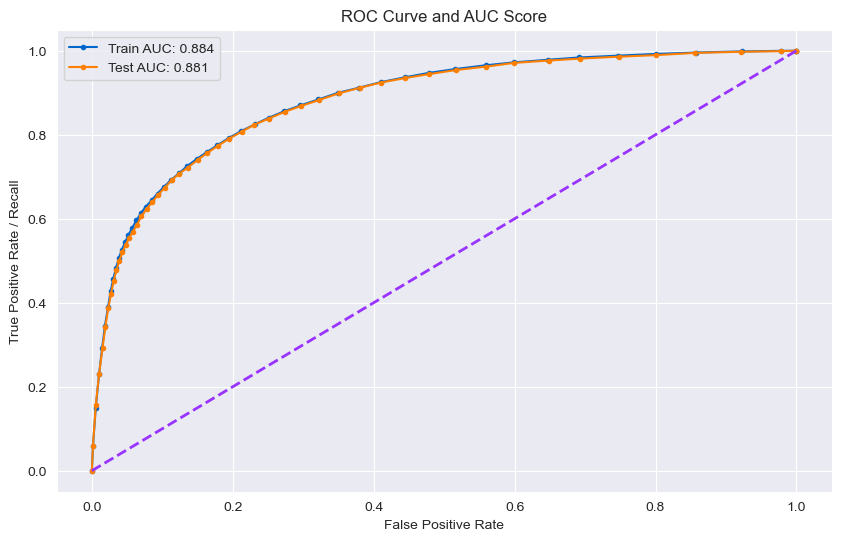

In [12]:
# Plot the roc curve 
print('======='*8)
print('ROC Curve: Logistic Regression Final Model')
print('======='*8)
evaluator.plot_roc_auc_curve(X_train, X_test, y_train, y_test)

All metrics match those from the advanced modeling, confirming that predictions on the training and test data have been successfully reproduced. I will now proceed to interpret the model.

---

## 3. Interpreting the Model/Coefficients <a class="anchor" id="3"></a>

- In this section, I will retrieve the coefficients from the logistic regression model, rank and plot the most impactful features, interpret their significance, and derive insights into the primary factors contributing to the risk of having a heart attack. Additionally, I will discuss potential preventive actions that can be taken to mitigate this risk.
- The logistic regression model is trained on scaled features, meaning that the coefficients correspond to the scaled feature space rather than the original feature space.
- To facilitate interpretation, I will convert the coefficients back to the original feature space, allowing them to be understood in terms of the odds of experiencing a heart attack.

---

### 3.1 Retrieve and Transform Coefficients <a class="anchor" id="3a"></a>

Retrieve the preprocessor (one-hot-encoder), scaler (standard scaler), and the logistic regresson model from the final_model pipeline

In [13]:
# Get the one-hot-encoder from the final_model pipeline
preprocessor = final_model.named_steps['encoding'] 

# Get the standard scaler from the final_model pipeline
scaler = final_model.named_steps['scaler']

# Get the logistic regression model from the final_model pipeline
logreg = final_model.named_steps['logreg']

Retrieve the feature names after one hot encoding

In [14]:
# Get the feature names of the logistic regression
feature_names = preprocessor.get_feature_names_out()
feature_names[[0, 1, 2, -3, -2, -1]]

array(['cat_cols__race_ethnicity_category_Asian',
       'cat_cols__race_ethnicity_category_Black',
       'cat_cols__race_ethnicity_category_Hispanic',
       'num_cols__physical_activities', 'num_cols__had_angina',
       'num_cols__had_stroke'], dtype=object)

Due to one hot encoding, the feature names are not correctly displayed, I need to remove the 'cal_cols__' and 'num_cols__' in the beginning.

In [15]:
# Rename the features to remove starting pattern of cat_cols__ or num_cols__
feature_names = np.array([re.sub(r'(cat_cols__)|(num_cols__)', '', name) 
                          for name in feature_names])
feature_names[[0, 1, 2, -3, -2, -1]]

array(['race_ethnicity_category_Asian', 'race_ethnicity_category_Black',
       'race_ethnicity_category_Hispanic', 'physical_activities',
       'had_angina', 'had_stroke'], dtype='<U35')

To interpret the coefficients in the original feature space, we need to transform them back from their scaled version. The transformation can be done using the formula:

$$\text{unscaled\_coefficients} = \frac{\text{scaled\_coefficients}}{\text{standard deviation of the feature}}$$

In [16]:
# Retrieve and transform it in to unscaled coefficients
unscaled_coefficients = logreg.coef_[0] / scaler.scale_

In [17]:
# Create a DataFrame to store the feature names and coefficients
features = pd.DataFrame(
    data=unscaled_coefficients, 
    index=feature_names, 
    columns=['coefficients']
    ).sort_values(by='coefficients', ascending=False)

# Create a column to turn coefficients into change of odds of having a heart attack
features['odds'] = np.exp(features['coefficients'])

In [18]:
# Check the top 10 features
top_features = features.head(10)
top_features

,coefficients,odds
had_angina,2.190416,8.938930
had_stroke,1.077941,2.938622
age_category_80+,0.766557,2.152343
age_category_75-79,0.548910,1.731364
general_health_Poor,0.484267,1.622986
age_category_70-74,0.418379,1.519497
smoker_status_Every day smoker,0.361449,1.435408
general_health_Fair,0.350331,1.419537
general_health_Unknown,0.329629,1.390452
smoker_status_Some days smoker,0.274731,1.316176


In [19]:
# Check the bottom 6 features
bottom_features = features.tail(6)
bottom_features 

,coefficients,odds
is_female,-0.592808,0.552773
age_category_40-44,-0.683696,0.504748
age_category_35-39,-0.910613,0.402278
age_category_30-34,-1.117730,0.327021
age_category_25-29,-1.304784,0.271231
age_category_18-24,-1.451391,0.234244


### 3.2 Interpreting Coefficients <a class="anchor" id="3b"></a>

Text(0.5, 1.0, 'Most Influential Factors in Heart Attack Risk Prediction')

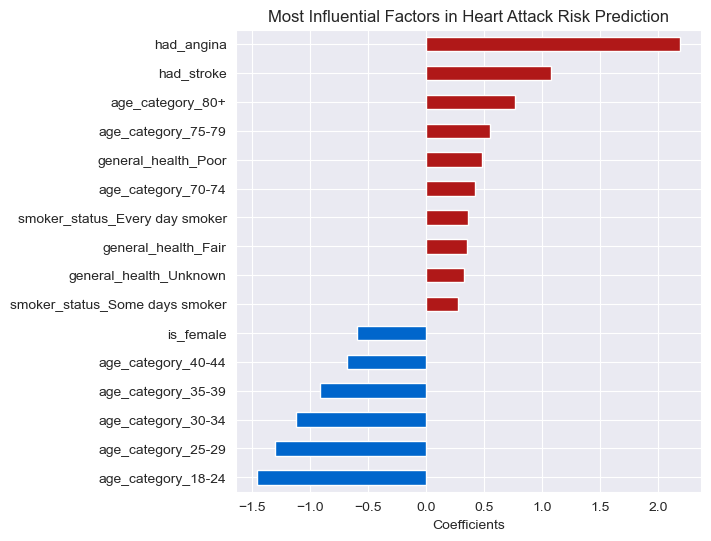

In [20]:
# Create a DataFrame to store top and bottom features
important_features = pd.concat([top_features, bottom_features], axis=0).sort_values(by='coefficients')
colors = ['#0066CC'] * 6 + ['#B01818'] * 10

important_features['coefficients'].plot(kind='barh', color=colors)
plt.xlabel('Coefficients')
plt.title('Most Influential Factors in Heart Attack Risk Prediction')

| Feature Name      | Coefficients | Odds     | Interpretation                   |
|-------------------|--------------|----------|---------------------------------------|
| had_angina        | 2.19        | 8.94     | 1. Angina is chest pain or discomfort that occurs when the heart muscle does not receive enough oxygen-rich blood <br> 2. The presence of angina is a strong indicator of the risk of heart attack, as individuals who have had angina have **8.94 times** the odds of having a heart attack compared to those who haven't experienced angina.   |
| had_stroke        | 1.08       | 2.94     | 1. A stroke is a medical emergency that occurs when blood flow to a part of the brain is interrupted or reduced <br> 2. The presence of stroke is also a powerful indicator of the risk of heart attack. Individuals who have experienced stroke have **2.94 times** the odds of having a heart attack compared to those who haven't had stroke.              |
| age_category_80+  | 0.77       | 2.15     | When individuals reach the age of 80, their likelihood of having a heart attack increases significantly. In fact, their odds of experiencing a heart attack are 2.15 times higher compared to those under the age of 80  |
| general_health_Poor | 0.48     | 1.62     | This variable represents respondents who answered 'Poor' when asked to describe their general health condition. Individuals who perceive their general health as poor have odds of having a heart attack that are 1.62 times higher than those who do not.  |
| smoker_status_Every day smoker   | 0.36  |1.44  | The odds of individuals who smoke every day are 1.44 times higher than those who do not smoke daily."  |
| is_female         |-0.59       | 0.55     | Female is less likely to experience a heart attack. In fact, the odds of experiencing a heart attack is 0.55 lower than male.   |
| age_category_18-24 | -1.45     | 0.23     | Young individuals are less likely to experience a heart attack. The odds of having a heart attack for individuals aged 18 to 24 are 0.23 times lower compared to those aged 25 and older |

#### Takeaways
**Demographics**: <br>
1. Age: From the findings in EDA, Age is exponentially correlated with heart attack risk, notably increasing after 45. Individuals aged 80+ are among the top predictors, while those aged 18-24 have much lower odds.
2. Gender: Data suggests females have a lower likelihood of heart attacks, though it is a less significant predictor compared to other features.
 
**Medical History**:<br>
1. Angina: Angina is a critical indicator of heart attack risk. Individuals with chest pain due to insufficient blood flow should immediately consult doctors not only on angina, but also on follow-up checkup of heart attack risk.
2. Stroke: A history of stroke is a significant risk factor for heart attacks. Stroke patients should consult doctors to evaluate their heart attack risk.

**Health Condition and Life Style**:<br>
1. Smoking habit: From the EDA findings, smoking frequency is positively correlated with heart attack risk. Higher smoking frequency gradually increases the odds of having a heart attack, supporting these findings.
1. Genderal health condition: General health condition reflects individuals' perceptions of their health. Those who view their health as poor face increased odds of having a heart attack. It's advisable for these individuals to consult doctors and assess their heart attack risk. While improving self-perception may appear to lower the likelihood in the model, it should not be considered a preventive measure, as heart attack risk is primarily determined by physical condition rather than personal 
opinion.

---

## 4. Breakdown Analysis of Recall and False Positive Rate<a class="anchor" id="4"></a>


In this section, I will conduct a deeper analysis of recall and false positives by examining each feature category to assess their respective recall and false positive rates. For example:

1. From the previous analysis, we understand that `had_angina` As previously noted, angina is a significant predictor in our model, with individuals experiencing angina having nearly nine times the odds of having a heart attack compared to those without it. However, for individuals who did not experience angina, what is the model's capability in identifying those who are genuinely at risk for a heart attack (recall score/true positive rate)? Additionally, for those who experienced angina but are not actually at risk for a heart attack, what proportion receives a false alarm (false positive rate)?"
2. For individuals aged 80+ from `age_category` feature, what is the model's effectiveness in identifying those who are actually at risk of a heart attack (recall score)? Simultaneously, for those aged 80+ who are not at risk, what proportion receives a false alarm (false positive rate)?

This analysis will provide valuable insights into how the model's performance varies with different personal conditions and highlight its limitations across various features. 

---


### 4.1 Retrieve the Prediction Outcomes of Test Data <a class="anchor" id="3a"></a>

Create a DataFrame of test data, along with y_test, and y_pred_test

In [21]:
# Concatenate X_test, y_test
test_df = pd.concat([X_test, y_test], axis=1)

In [22]:
# Create a new column to store y_pred_test
test_df['y_pred'] = y_pred_test

In [23]:
# Check the shape of test_df
print(f'The test data after combining y_true and y_test is {test_df.shape}')

The test data after combining y_true and y_test is (187997, 21)


In [24]:
# Show the head of test_df
test_df.head().T

,380384,481882,603241,638326,52029
is_female,1,0,0,1,0
race_ethnicity_category,Black,Unknown,Hispanic,Hispanic,White
age_category,75-79,25-29,60-64,65-69,60-64
bmi_category,overweight,obese,healthy,overweight,obese
alcohol_drinkers,No,No,Yes,Yes,Yes
general_health,Good,Excellent,Fair,Fair,Good
smoker_status,Former,Never,Every day smoker,Never,Never
physical_activities,1,1,0,1,1
had_angina,0,0,0,0,0
had_stroke,0,0,0,0,0


In [25]:
# Rename the had_heart_column to y_true
test_df = test_df.rename(columns={'had_heart_attack' : 'y_true'})

Create a new columns to store the value if the prediction is True Positive, False Positive, True Negative, False Negative

In [26]:
# Create a new fuction to return the outcome of the prediction
def get_prediction_outcome(y_true, y_pred):
    """"
    The function compares the true value and prediction value, and return the out come of 
    the prediction is: True Positive(TP), True Negative(TN), False Positive(FP), False Negative(FN)

    Args:
        y_true(array): The true value of y
        y_pred(array): The predicted value of y

    Returns:
        String: One of the outcomes: TP, TN, FP, FN
    """

    if (y_true == 1) and (y_pred == 1):
        return 'True Positive'
    elif (y_true == 0) and (y_pred == 0):
        return 'True Negative'
    elif (y_true == 1) and (y_pred == 0):
        return 'False Negative'
    elif (y_true == 0) and (y_pred == 1):
        return 'False Positive'

In [27]:
# Create a new column to store the column outcome
test_df['prediction_outcome'] = test_df.apply(lambda row: get_prediction_outcome(row['y_true'], row['y_pred']), axis=1)

In [28]:
# Sanity check
test_df[['y_true', 'y_pred', 'prediction_outcome']].head()

,y_true,y_pred,prediction_outcome
380384,0,0,True Negative
481882,0,0,True Negative
603241,0,1,False Positive
638326,0,0,True Negative
52029,0,0,True Negative


In [29]:
# Sanity check
test_df['prediction_outcome'].value_counts()

prediction_outcome
True Negative     141866
False Positive     36210
True Positive       7927
False Negative      1994
Name: count, dtype: int64

The values of TN, FP, TP, FN are consistent with the numbers in the confusion matrix shown in section 2.

### 4.2 Visualize Recall and False Positive Rate for Each Feature & Interpretations<a class="anchor" id="4b"></a>

1. All of the features used for training the final model are categorical
2. I will use a for loop to iterate through each feature, within each iteration, I will plot the recall score and false positive rate for each category within that specific feature

In [30]:
# Retrieve the feature columns
feature_cols = X_test.columns

# Get the number of iterations 
len(feature_cols)

19

prediction_outcome,False Negative,False Positive,True Negative,True Positive,Recall,FPR
age_category,,,,,,
18-24,38,20,11780,6,0.136364,0.001695
25-29,58,25,9518,4,0.064516,0.002620
30-34,61,55,10930,19,0.237500,0.005007
35-39,87,119,11845,32,0.268908,0.009947
40-44,87,318,12184,70,0.445860,0.025436
45-49,112,578,11273,155,0.580524,0.048772
50-54,163,1390,12370,319,0.661826,0.101017
55-59,173,2730,12064,560,0.763984,0.184534
60-64,269,3936,13725,925,0.774707,0.222864


prediction_outcome,False Negative,False Positive,True Negative,True Positive,Recall,FPR
had_angina,,,,,,
0,1990,30273,141831,3123,0.610796,0.175899
1,4,5937,35,4804,0.999168,0.994139


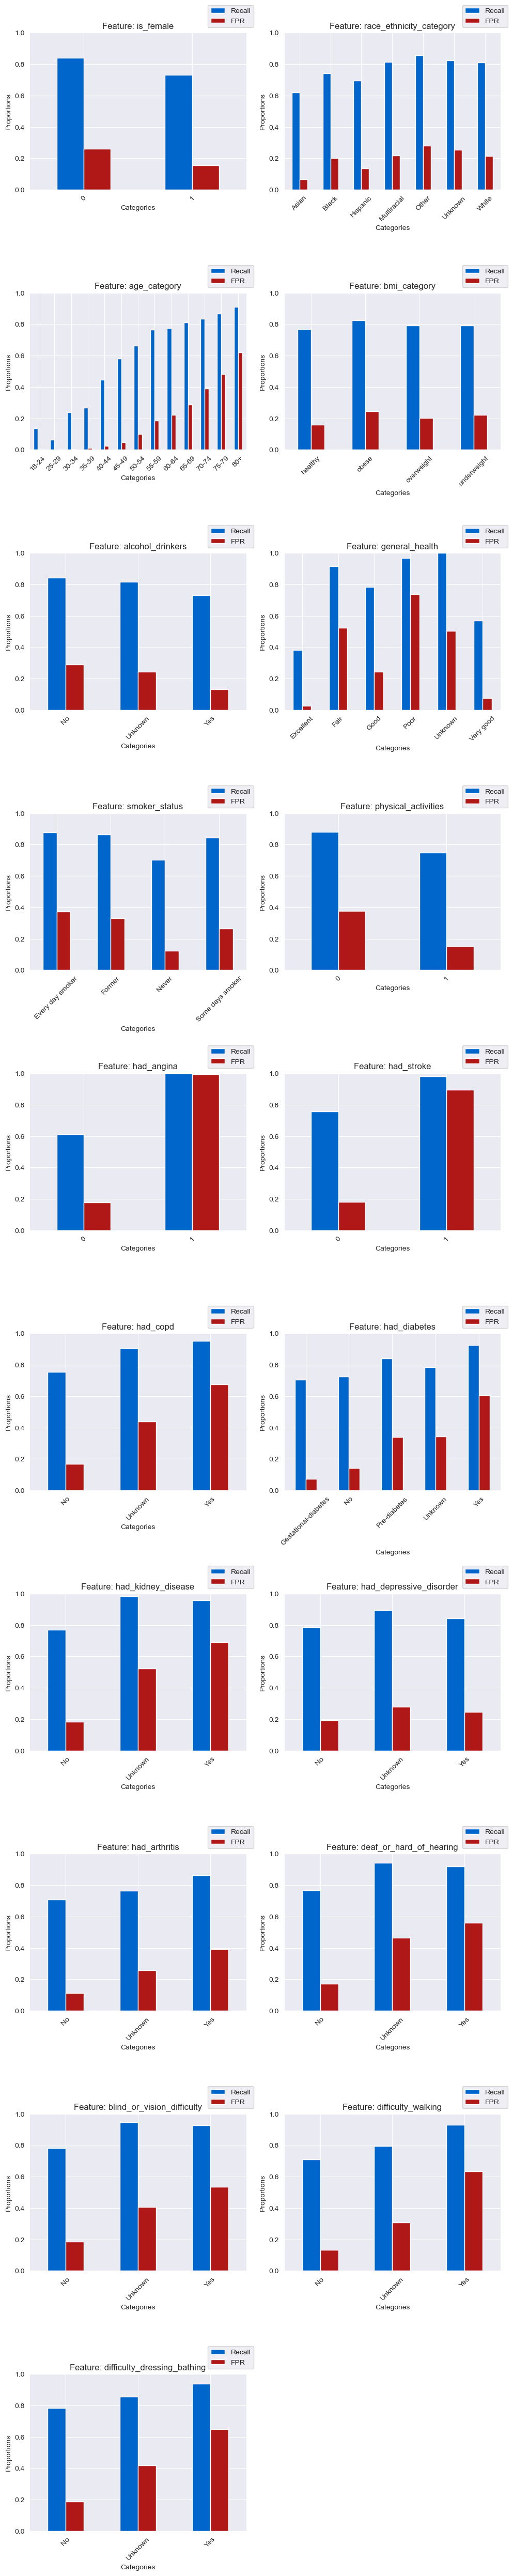

In [31]:
# Instantiate the subplot
fig, axes = plt.subplots(10, 2, figsize=(10, 50))  

# Flatten the 2D array of axes for easy iteration
axes = axes.flatten()  

# Loop through each feature column and create a plot
for i, col in enumerate(feature_cols):

    # Create crosstable to get the count of prediction outcome
    outcome_counts = pd.crosstab(test_df[col], test_df['prediction_outcome'])

    # Calculate Recall
    outcome_counts['Recall'] = (outcome_counts['True Positive'] 
                                / (outcome_counts['True Positive'] + outcome_counts['False Negative']))

    # Calculate False Positive Rate
    outcome_counts['FPR'] = (outcome_counts['False Positive'] /
                                              (outcome_counts['False Positive'] + outcome_counts['True Negative']))
    

    # Display the crosstable if the feature is age_category or had_angina
    if col in ['age_category', 'had_angina']:
        display(outcome_counts)

    # Create the bar plot in the corresponding subplot
    outcome_counts[['Recall', 'FPR']].plot(kind='bar', ax=axes[i], color={'FPR': '#B01818', 'Recall': '#0066CC'})
    axes[i].set_title(f'Feature: {col}')  
    axes[i].set_xlabel('Categories')  
    axes[i].set_ylabel('Proportions') 
    axes[i].set_ylim(0, 1)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(loc='upper right', bbox_to_anchor=(1.05, 1.20))

# Hide any remaining empty subplots
fig.delaxes(axes[19])

plt.tight_layout()  
plt.show()

**Analysis**:
1. The tradeoff between recall and false positive rate is evident across all features. As the model's ability to identify individuals at risk for heart attacks improves, the proportion of false alarms among those not at risk also increases.
2. `age_category`: <br>The recall scores for age groups between 18 and 44 are lower than 50%, with even poorer performance for those under 30. In addition, the false positive rate for those who's above 75 are relatively high. By looking at the tables above the plot, I found:
    - Recall is calculated by TN/(TN+FP). Among 11,884 observations in the age 18-24 group, only 44 people who actually face the risk of heart attack. Due to the extreme imbalance in this group, the model learns that people within this age range are very unlikely to be at risk for a heart attack, leading it to incorrectly predict that individuals are free from heart attack risk while actually they are not. In fact, only 6 out of the 44 individuals at risk are correctly identified.
    - Given the low number of observations for individuals at risk of heart attacks, the recall score is less reliable and may vary significantly with different test datasets. 
    - As individuals age, their likelihood of experiencing a heart attack increases, and the model learns this pattern. However, it tends to overestimate the risk. For example, in the age group of 80 and above, out of 15,577 individuals, the model correctly identifies 90.3% of those at risk for a heart attack but also incorrectly raises alarms for 62% of individuals who are not at risk. 
3. `had_angina`: 
    - The model demonstrates moderate effectiveness in identifying individuals without prior angina, correctly identifying over 60% of those at risk of heart attack. Notably, its predictions for this group are do not solely rely on angina medication history, suggesting additional factors contribute to its decision-making.
    - However, the model exhibits a critical limitation for individuals with angina who are not at risk of heart attack: nearly 100% of these cases receive false-positive alerts. This stems from a key imbalance in the dataset. While only 5.3% of the overall population experienced a heart attack, exploratory data analysis (EDA) revealed that 45.4% of individuals with angina did have a heart attack. This disproportionate association leads the model to overemphasize angina as a predictor, disproportionately flagging almost all angina patients as exhibiting heart attack risk, thereby inflating the false-positive rate.
4. `had_stroke`, `had_copd`, `had_diabetes`, `had_kidney_disease`, `difficult_walking`, `difficulty_dressing_bathing`: 
    - The EDA indicates that individuas with these medical histories or movement limitations exhibit a higher likelihood of having a heart attack. While the model successfully identifies this predictive association, it overemphasizes these variables in isolation, Consequently, over 60% of individuals with these above medical histories or mobility limitations—who actually face no heart attack threat—receive false-positive alerts, underscoring the need for supplementary diagnostic validation.

**Takeaways/Model Limitations**:
1. Individuals who are between 18-44 and concerned about their heart attack risk should not alleviate their worries solely based on 'Negative' prediction results from the model.
2. Individuals over 70 should not immediately take preventive measures based solely on 'Positive' alerts from the model. Instead, they should consult with healthcare professionals or consider using alternative models that employ different features to further validate their heart attack risk.
3. The model is highly likely to flag individuals with a history of angina as at-risk for heart attack. However, users in this category should not rely exclusively on the model’s alert to determine their course of action. Instead, the results should be supplemented with consultations with healthcare professionals and detailed clinical evaluations (e.g., blood tests, imaging, stress tests) to conduct a comprehensive assessment of their actual heart attack risk.
4. For users flagged as positive heart attack risk by the model—particularly those with a medical history (stroke, COPD (Chronic Obstructive Pulmonary Disease), diabetes, kidney disease) or mobility limitations (difficulty walking, dressing, or bathing)—supplemental diagnostic measures are critical to mitigate false-positive alerts. Due to the model’s tendency to overemphasize these variables as standalone predictors, individuals in this category should prioritize consulting healthcare professionals and undergoing clinical evaluations.

---

## 5. Project Summary <a class="anchor" id="5"></a>

### Problem 
1.  Heart attacks are a leading cause of death in the U.S., impacting over 800,000 individuals annually, highlighting the critical need for early intervention.
2. Gaps in existing cardiovascular risk calculators: 
    - Impose strict age restrictions (30–79 years), excluding younger and older populations.
    - Require blood-test-dependent inputs (e.g., cholesterol levels), limiting accessibility for routine screening.

### Solution
1. Proactive Risk Identification: Develop an early detection system to identify heart attack risk, empowering individuals to adopt preventive actions.
2. Higher Accessibility:
    - Broaden age eligibility to users as long as their age is 18+.
    - Leverage readily available features such as demographics, medical history, lifestyle habits, and self-reported health indicators—to eliminate dependency on lab tests.

### Metrics of Success
1. Primary Objective (Recall): Maximize identification of true at-risk individuals, measured by recall score.
    - Rationale: Aligns with the business goal of prioritizing early intervention for individuals who actually exhibit heart attack risk.
2. Secondary Objective (False Positive Rate): Control unnecessary healthcare checkup cost by limiting false alarms, measured by false positive rate (FPR).
    - Rationale: False positives trigger avoidable clinical evaluations (e.g., consultations, x-ray), incurring unnecessary cost of money and time.
3. Based on research regarding heart attacks and the performance metrics of existing calculators, I understand that approximately 10% to 30% of heart attacks are attributed to randomness or unexplainable factors, making them challenging to predict using established patterns. From my analysis of baseline models, I have observed that most machine learning models typically achieve a recall of around 0.76 and a false positive rate of approximately 0.2. Consequently, I have set the target metrics for my project to achieve a recall of 0.8 while keeping the false positive rate below 0.2.

### Data Quality Check and Preprocessing
1. Missing values present a critical challenge, with 74.7% of observations and 91.9% of features containing at least one missing value. After several rounds of data cleaning and imputation—such as removing observations with more than 50% missing values and imputing height and weight using mean and median values—85.6% of the observations were retained.
2. Another significant issue is the extreme class imbalance in the target variable, with only 5.3% of observations indicating a heart attack. To enhance model performance, resampling techniques and weight adjustments were implemented during the modeling process.
3. To prepare the data for modeling, log transformation, one-hot encoding, and feature engineering techniques were applied.


### EDA findings
1. Age:
    - Heart attack risk increases exponentially after age 45.
    - Most existing models exclude individuals aged 80+, leaving this high-risk group inaccessible to early detection tools.

2. Angina:
    - Angina is a type of chest pain or discomfort caused by reduced blood flow to the heart muscle.
    - Respondents with angina have a 45.4% likelihood of experiencing a heart attack—nearly 9x higher than the baseline population (5.3%).

3. Stroke:
    - Stroke is a medical emergency that occurs when blood flow to a part of the brain is interrupted or reduced
    - Individuals who have experienced stroke exhibit a significantly elevated risk of heart attack as the likelihood is 4.7x higher than the baseline population.

4. Self-reflection of General Health Condition:
    -  Individuals rating their health as "Poor" have a 14.2x higher risk of heart attack than those rating it "Excellent", highlighting the predictive value of subjective health perceptions.

5. Smoker Status:
    - Smoking frequency is positively correlated with heart attack likelihood, with 'Every Day Smoker' at highest risk, and 'Some Days Smoker' at second hightest.

### Model & Interpretations
1. Multiple models, including Logistic Regression, Naive Bayes, Decision Tree, Random Forest, XGBoost, and Neural Networks, were trained to predict the risk of heart attacks in users. Logistic Regression outperformed the other models, achieving a high recall score while effectively controlling the false positive rate, and was therefore selected as the final model
2. Performance on Test Data:
    - Recall: Correctly identified 79.9% of true at-risk individuals, aligning with the project’s priority to maximize early detection.
    - False Positive Rate: 20.3% of not-at-risk individuals received false alarms.
3. Key Interpretations:
    - The presence of angina or a history of stroke has a significant impact on predicting heart attack risk. 
    - Age is positively correlated with this risk; the model predicts that individuals aged 18-44 have lower odds of experiencing a heart attack, while those over 70 have significantly higher odds.
    - Smoking frequency also correlates with heart attack risk, with daily smokers predicted to have higher odds of experiencing a heart attack.
    - Individuals who assess their general health condition as 'Poor' have higher predicted odds of experiencing heart attacks, while those who rate their health as 'Excellent' have lower odds, according to the model's predictions.

### Limitations
1. For Younger Adults (Ages 18–44):

    - Caution with "Negative" Results: Individuals in this age group should not discount their heart attack risk solely based on a "Negative" prediction from the model. The model underestimates the risk because positive cases are very infrequent in this age group.

    - Action: Seek clinical evaluation if symptoms (e.g., chest pain, shortness of breath) persist, even with a "Negative" result.

2. For Older Adults (Age 70+):

    - Caution with "Positive" Alerts: A "Positive" result should not prompt immediate interventions without validation. Age is a strong predictor in the model, but it is essential to consider the overall clinical context and individual patient factors before making decisions based 'Positive' alarm.

    - Action: Consult healthcare professionals; consider supplementary tools (e.g., blood-test based risk calculators) for cross-validation.

3. Individuals with Angina History:

    - Caution with High False-Positive Likelihood (Almost 100%): The model overweights angina history as a dominant risk factor, leading to frequent false alarms for those who experienced angina.

    - Action: Do not rely on model predictions if user had angina. Treat model alerts as preliminary indicators, not definitive diagnoses.

4. Individuals with a history of stroke, COPD (Chronic Obstructive Pulmonary Disease), diabetes, kidney disease, or those experienced mobility difficulties: 

    - Caution with High-Positive Likelihood (About 50%):  The model tends to overemphasize these variables in isolation, leading to a frequent false alarm for those who exhibit these disease. 

    - Action: Implement clinic diagnose for individuals flagged by the model. Combine supplementary tools (e.g., blood-test based risk calculators) for for holistic evaluation

5. General Health Self Assessment:
    -  Self-assessment of health conditions is subjective, and changes in a user's self-reflection may influence the prediction results without necessarily correlating to an actual change in heart attack risk.
    - Action: Individuals who rate their general health condition as 'Poor' should consult healthcare providers for a comprehensive assessment of their heart attack risk. It is important for people to objectively reevaluate their health condition when providing self-assessments.


### Contact
If you have any question or are interested in having a discussion, please contact: (yehuanwu2912@gmail.com)
or [LinkedIn](https://www.linkedin.com/in/willwu2912/) <br> Thank you!